<a href="https://colab.research.google.com/github/matthiasdialpad/pCSAT/blob/master/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import string
import torch
import itertools
import seaborn as sns
from tqdm import tqdm
from google.cloud import bigquery
from google.cloud import storage
from datetime import date
from google.colab import files, auth
import matplotlib.pyplot as plt
auth.authenticate_user()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install transformers

     |████████████████████████████████| 778kB 4.1MB/s 
     |████████████████████████████████| 890kB 21.3MB/s 
     |████████████████████████████████| 3.0MB 29.4MB/s 
     |████████████████████████████████| 1.1MB 36.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=92fae6ac4f233dcb045c914f7e1f854afc4039d3ecf1c09464ee9e8d1cf177eb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
#Annotating labels for plots
def annotate_labels(ax, labels_list, **kwargs):
    """
    Function to automatically add labels on bar charts.
    It takes a plot axis, an ordered list of labels, and text kwargs.
    """
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom
    
    rects = ax.patches

    for rect, label in zip(rects, labels_list):
        height = rect.get_height()
        p_height = (height / y_height) # Fraction of axis height taken up by this rectangle
        label_position = height + (y_height * 0.01)
        
        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column (or else, change ylim)
        #if p_height > 0.95:
        #    label_position = height - (y_height * 0.05)
        #else:
        #    label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/3, label_position, label, kwargs)
    return None

In [4]:
project_id = 'talkiq-data'
metrics_dest_table = 'ai_research.csat_utterance'
client = bigquery.Client(project=project_id)

In [5]:
query = """
SELECT *
FROM `talkiq-data.ai_research.csat_utterance`
"""

In [6]:
def read_from_database(query):
    query_job = client.query(query)  
    df = query_job.to_dataframe()
    print('Done')
    return df

In [7]:
df = read_from_database(query)

Done


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184993 entries, 0 to 1184992
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype              
---  ------               --------------    -----              
 0   call_id              1184993 non-null  object             
 1   call_leg_id          1184993 non-null  object             
 2   call_side            1184993 non-null  object             
 3   response_value       1184993 non-null  object             
 4   response_csat_value  23931 non-null    object             
 5   final_utterance      1184993 non-null  object             
 6   time_start           1184993 non-null  float64            
 7   time_end             1184993 non-null  float64            
 8   PARTITIONTIME        1184993 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), object(6)
memory usage: 81.4+ MB


In [9]:
df[['response_value']] = df[['response_value']].astype(str).astype(int)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184993 entries, 0 to 1184992
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype              
---  ------               --------------    -----              
 0   call_id              1184993 non-null  object             
 1   call_leg_id          1184993 non-null  object             
 2   call_side            1184993 non-null  object             
 3   response_value       1184993 non-null  int64              
 4   response_csat_value  23931 non-null    object             
 5   final_utterance      1184993 non-null  object             
 6   time_start           1184993 non-null  float64            
 7   time_end             1184993 non-null  float64            
 8   PARTITIONTIME        1184993 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(5)
memory usage: 81.4+ MB


In [11]:
df.head()

,call_id,call_leg_id,call_side,response_value,response_csat_value,final_utterance,time_start,time_end,PARTITIONTIME
0,4503600102440960,322a83c9-8a7d-4b4a-ba5b-3cb1528064bc,caller,5,None,This is Daniel. How can I help?,0.445,3.265,2019-12-26 00:00:00+00:00
1,4503600102440960,b19f3ce7-232b-45d6-94bd-0c1ae388b583,callee,5,None,"Yes, no ma'am. Um, before the came to talk the...",4.335,16.725,2019-12-26 00:00:00+00:00
2,4503600102440960,322a83c9-8a7d-4b4a-ba5b-3cb1528064bc,caller,5,None,"Okay, let me see here, let me pull up your ord...",17.845,21.955,2019-12-26 00:00:00+00:00
3,4503600102440960,322a83c9-8a7d-4b4a-ba5b-3cb1528064bc,caller,5,None,This is Graham.,26.245,28.045,2019-12-26 00:00:00+00:00
4,4503600102440960,b19f3ce7-232b-45d6-94bd-0c1ae388b583,callee,5,None,Yes.,28.935,29.475,2019-12-26 00:00:00+00:00


In [12]:
df.groupby(['response_value'])['call_id'].nunique()

response_value
1     3217
2      670
3     1347
4     2366
5    21536
Name: call_id, dtype: int64

In [13]:
#There are duplicates for some of these call_id
temp_df=df.groupby(['call_id','PARTITIONTIME']).response_value.nunique().reset_index()
df2 = temp_df.groupby(['call_id'])['response_value'].count().sort_values(ascending=False).reset_index()
df2[df2.response_value > 1]

,call_id,response_value
0,6449392798007296,2
1,4644280161140736,2
2,5955473547067392,2
3,5090793660219392,2
4,6135111594409984,2
...,...,...
135,4830409573400576,2
136,5680734161207296,2
137,6504792381587456,2
138,4992292990550016,2


In [14]:
#Example of calls with duplicate utterances
df[df.call_id == '5774478919204864']

,call_id,call_leg_id,call_side,response_value,response_csat_value,final_utterance,time_start,time_end,PARTITIONTIME
840466,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,Home Depot installations by Romanov. This is T...,0.16,3.94,2019-09-30 00:00:00+00:00
840467,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"Hi, yeah, um, my name is Yolanda and I have a,...",4.80,19.89,2019-10-01 00:00:00+00:00
840468,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"Hi, yeah, um, my name is Yolanda and I have a,...",4.80,19.89,2019-09-30 00:00:00+00:00
840469,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,"Okay,",13.36,13.84,2019-09-30 00:00:00+00:00
840470,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,"Alright, I'm sorry about that. Do you mind giv...",21.16,25.48,2019-09-30 00:00:00+00:00
840471,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"Yeah, just a second. I'll tell you one sec. I ...",25.80,30.63,2019-09-30 00:00:00+00:00
840472,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"Yeah, just a second. I'll tell you one sec. I ...",25.80,30.63,2019-10-01 00:00:00+00:00
840473,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"It's, uh, 815-997-7852.",34.20,41.28,2019-10-01 00:00:00+00:00
840474,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"It's, uh, 815-997-7852.",34.20,41.28,2019-09-30 00:00:00+00:00
840475,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,"Okay,",42.76,43.39,2019-09-30 00:00:00+00:00


In [15]:
#Removing duplicate utterances. 
temp_df = df.sort_values(by=['call_id','time_start','PARTITIONTIME'])
df3 = temp_df.drop_duplicates(subset=['final_utterance','call_leg_id'], keep='last')

In [16]:
#Removed calls with duplicate utterances. Now check if there are any more calls with different partition time with same call id. 
#Results show that in fact there are. After investigating some of these calls and cross checking their validty with the call stitcher notebook 
#@ https://colab.research.google.com/drive/1yw4Yea3FcfM6vZoAWos9Eoieqthfb5I1#scrollTo=xCqCO3U5QtGB, these calls are in fact stitched correctly. 

temp_df=df3.groupby(['call_id','PARTITIONTIME']).response_value.nunique().reset_index()
df4 = temp_df.groupby('call_id')['response_value'].count().sort_values(ascending=False).reset_index()
df4[df4.response_value > 1]

,call_id,response_value
0,6699679976849408,2
1,5774478919204864,2
2,5955473547067392,2
3,4642921500246016,2
4,5198578406260736,2
...,...,...
70,5216491674664960,2
71,5378413982253056,2
72,4562408767029248,2
73,4674786265268224,2


In [17]:
#Example of a call from above. As you can see, the partitiontime for the callee and caller are different but they belong in the same call_id
df3[df3.call_id == '5198578406260736'].head()

,call_id,call_leg_id,call_side,response_value,response_csat_value,final_utterance,time_start,time_end,PARTITIONTIME
738159,5198578406260736,0e46733a-61a6-4d06-84f9-62d3b7964c4b,caller,5,None,Thanks for calling the street. This is Amanda ...,3.0,6.27,2019-09-29 00:00:00+00:00
738160,5198578406260736,a638bb27-04f6-4163-ad6d-e36d51c04c20,callee,5,None,"Hi manda, uh, Sandra cross here and I'd like t...",7.2,16.59,2019-09-28 00:00:00+00:00
738161,5198578406260736,0e46733a-61a6-4d06-84f9-62d3b7964c4b,caller,5,None,What is your email address please?,15.6,18.69,2019-09-29 00:00:00+00:00
738162,5198578406260736,a638bb27-04f6-4163-ad6d-e36d51c04c20,callee,5,None,"S-L-S, as in Sam L., Lee Ross she R-O-F-F one ...",19.2,28.71,2019-09-28 00:00:00+00:00
738163,5198578406260736,0e46733a-61a6-4d06-84f9-62d3b7964c4b,caller,5,None,I'm sorry that's the same our.,31.2,34.50,2019-09-29 00:00:00+00:00


In [18]:
#Checking class distribution
df3.groupby(['response_value'])['call_id'].nunique()

response_value
1     3217
2      670
3     1347
4     2366
5    21536
Name: call_id, dtype: int64

In [333]:
df3[df3["final_utterance"].str.contains(r"(\bum(\,|\.|\s|\?|\!))")] #[6:11]

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,call_id,call_leg_id,call_side,response_value,response_csat_value,final_utterance,time_start,time_end,PARTITIONTIME
12,4503600102440960,322a83c9-8a7d-4b4a-ba5b-3cb1528064bc,caller,5,None,"On a, okay, gotcha on a way. Okay, good. Alrig...",78.445,87.715,2019-12-26 00:00:00+00:00
30,4503600102440960,0a47f561-6154-45c1-9b1c-50a65bfe61c7,caller,5,None,"Okay. Alright, perfect. So got you down for th...",684.184,722.794,2019-12-26 00:00:00+00:00
34,4503600102440960,0a47f561-6154-45c1-9b1c-50a65bfe61c7,caller,5,None,"Okay. Alright, perfect. Well, we'll see you th...",733.984,741.034,2019-12-26 00:00:00+00:00
111,4503914235691008,75f80586-42f0-49c7-a2d4-f5a2b17d2082,callee,5,None,"Hi, um, I got a message I believe it was from ...",4.200,29.550,2019-09-05 00:00:00+00:00
115,4503914235691008,75f80586-42f0-49c7-a2d4-f5a2b17d2082,callee,5,None,"Right, um, it, if you could do it on Monday or...",73.800,80.400,2019-09-05 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...
1147625,6755274570727424,e0823c57-436b-489f-acaf-63569b379ac3,caller,5,None,"Okay, um, can I get your phone number whole in...",54.050,57.260,2019-05-08 00:00:00+00:00
1147687,6755274570727424,e0823c57-436b-489f-acaf-63569b379ac3,caller,5,None,"Adjustable bad, they're hospital bed. Okay, an...",388.040,398.330,2019-05-08 00:00:00+00:00
1147691,6755274570727424,e0823c57-436b-489f-acaf-63569b379ac3,caller,5,None,"So they have room there to work and then, um, ...",415.880,425.300,2019-05-08 00:00:00+00:00
1147698,6755274570727424,e0823c57-436b-489f-acaf-63569b379ac3,caller,5,None,"They will, they can move those. Yeah, they'll ...",448.820,465.290,2019-05-08 00:00:00+00:00


In [19]:
# FILLER_WORDS: Set[str] = {
#     'er', 'um', 'ah', 'uh', 'mm', 'hm', 'hmm'
# }

#turn strings into lower case
df3["final_utterance"] = df3["final_utterance"].str.lower()

regex_patterns={
    # replace "uh.," "um.," "ah.," "mm.,", "oh.,!?" with blank but we leave uh-hum/mm-hmm in there
    r'(\buh(\,|\.|\s|\?))': ' ',
    r'(\bum(\,|\.|\s|\?))': ' ',
    r'(\bah\W)': ' ',
    r'(\bmm(\,|\.|\s|\!|\?))': ' ',
    r'(\boh(\,|\.|\s|\!|\?))': ' ',
    r'\boh\b': ' ',

    r'(\s*(?:\+?(\d{1,3}))?[-. (]*(\d{3})?[-. )]*(\d{3})[-. ]*(\d{4})(?: *x(\d+))?\s*)': ' ', # remove 10 digit and 7 digit numbers  e.g., 456-123-0000 and 123-0000
    r'(\d{3,})': '', # remove any numbers that has length 3 or more 
    r'\b(\w+)((?:\W+?)(\s+)?\1\b)+': r'\1', # replaces duplicate words with a single instance of that word. "yup, yup thank thank you. bye-bye" -> "yup thank you. bye" 
    r'([a-zA-Z0-9._-]+(\s+)?@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)': '[email]',
    r'(\bok\b)': 'okay',  #replaces "ok" with "okay"
    r'(ma\'am)': 'madam', #replaces ma'am with madam 
    r'(\s{2,})': ' '#replaces 2 or more whitespaces with a single one
}
    # #transform all negation into their full form
    # r"isn'\t":"is not", r"aren\'t":"are not", r"wasn\'t":"was not", r"weren\'t":"were not",
    # r"haven\'t":"have not", r"hasn\'t":"has not", r"hadn\'t":"had not", r"won\'t":"will not",
    # r"wouldn\'t":"would not", r"don\'t":"do not", r"doesn\'t":"does not", r"didn\'t":"did not",
    # r"can\'t":"can not", r"couldn\'t":"could not", r"shouldn\'t":"should not", r"mightn\'t":"might not",
    # r"mustn\'t":"must not"

In [20]:
%%time
df3['final_utterance'].replace(regex=regex_patterns, inplace=True)
df3['final_utterance'] = df3['final_utterance'].str.strip() #remove any spaces in the front and at the end of each call. 

#df3[df3["final_utterance"].str.contains(r'(ma\'am)')]
#res = df3["final_utterance"].str.findall(r'(\s*(?:\+?(\d{1,3}))?[-. (]*(\d{3})?[-. )]*(\d{3})[-. ]*(\d{4})(?: *x(\d+))?\s*)').to_frame()
#res.head()

CPU times: user 1min 32s, sys: 42.6 ms, total: 1min 32s
Wall time: 1min 32s


In [21]:
df_min = df3.groupby(['call_id'])['time_start'].min().reset_index()
df_max = df3.groupby(['call_id'])['time_end'].max().reset_index()
df_time = pd.merge(df_min, df_max, on='call_id')
df_time['duration'] = df_time.time_end - df_time.time_start
df_time.head()

,call_id,time_start,time_end,duration
0,4503600102440960,0.445,741.034,740.589
1,4503602697142272,0.590,71.609,71.019
2,4503732200472576,3.745,241.302,237.557
3,4503877562466304,0.836,266.756,265.920
4,4503914235691008,0.160,351.870,351.710


In [22]:
# combine all the utterances grouped by the call_id into a single conversation. 
df_combined = df3.groupby(['call_id', 'response_value']).agg({'final_utterance': ' '.join}).reset_index()
df4 = pd.merge(df_combined, df_time[['call_id', 'duration']], on='call_id')
df4.head()

,call_id,response_value,final_utterance,duration
0,4503600102440960,5,"this is daniel. how can i help? yes, no madam....",740.589
1,4503602697142272,1,"for jacob speaking. how can i help you? hi, ho...",71.019
2,4503732200472576,4,"thank you for calling the street, this is aman...",237.557
3,4503877562466304,5,"help you today? yes, i'm just calling to confi...",265.920
4,4503914235691008,5,"solution federal i'm an offer innovations, chr...",351.710


In [23]:
#!pip install transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [24]:
%%time 
df4['text_length'] = df4['final_utterance'].str.split().str.len()

#Get length of text using BERT tokenizer
df4['bert_tokenizer_length'] = df4.final_utterance.apply(lambda x: len(tokenizer.tokenize(x)))

CPU times: user 3min 46s, sys: 859 ms, total: 3min 47s
Wall time: 3min 47s


In [25]:
df4.head()

,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length
0,4503600102440960,5,"this is daniel. how can i help? yes, no madam....",740.589,513,694
1,4503602697142272,1,"for jacob speaking. how can i help you? hi, ho...",71.019,109,146
2,4503732200472576,4,"thank you for calling the street, this is aman...",237.557,217,279
3,4503877562466304,5,"help you today? yes, i'm just calling to confi...",265.920,588,753
4,4503914235691008,5,"solution federal i'm an offer innovations, chr...",351.710,694,910


In [26]:
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(df4['final_utterance'][0]))
    
len(tokenizer.tokenize(df4['final_utterance'][0]))

Tokenized:  ['this', 'is', 'daniel', '.', 'how', 'can', 'i', 'help', '?', 'yes', ',', 'no', 'madam', '.', 'before', 'the', 'came', 'to', 'talk', 'them', 'or', 'twenty', 'third', 'but', 'they', "'", 're', 'just', 'applied', 'one', 'end', 'yet', '.', 'so', 'how', "'", 's', 'that', 'bye', 'we', 'did', 'run', 'the', 'whole', 'number', 'one', 'last', 'will', 'be', 'in', 'on', 'the', 'th', '##ir', '##tie', '##th', '.', 'okay', ',', 'let', 'me', 'see', 'here', ',', 'let', 'me', 'pull', 'up', 'your', 'order', 'quick', '.', 'this', 'is', 'graham', '.', 'yes', '.', 'okay', ',', 'let', "'", 's', 'see', 'here', '.', 'this', 'is', ',', 'was', 'lam', '##inate', 'floor', '##ing', 'and', 'you', 'say', 'should', 'be', 'in', 'on', 'the', 'th', '##ir', '##tie', '##th', 'and', 'then', 'i', 'have', 'the', 'schedule', 'delivery', '.', 'they', 'say', 'anything', 'about', 'but', 'you', "'", 're', 'picking', 'it', 'up', '.', 'okay', '.', 'no', ',', 'not', 'picking', 'it', 'up', '.', 'i', "'", 'm', 'picking', '

694

In [27]:
#There are only 13,275 calls where there are less than 512 tokens
dfb = df4[df4.bert_tokenizer_length <= 512]
dfb.groupby(['response_value'])['call_id'].nunique()

response_value
1    2155
2     456
3     799
4    1154
5    8825
Name: call_id, dtype: int64

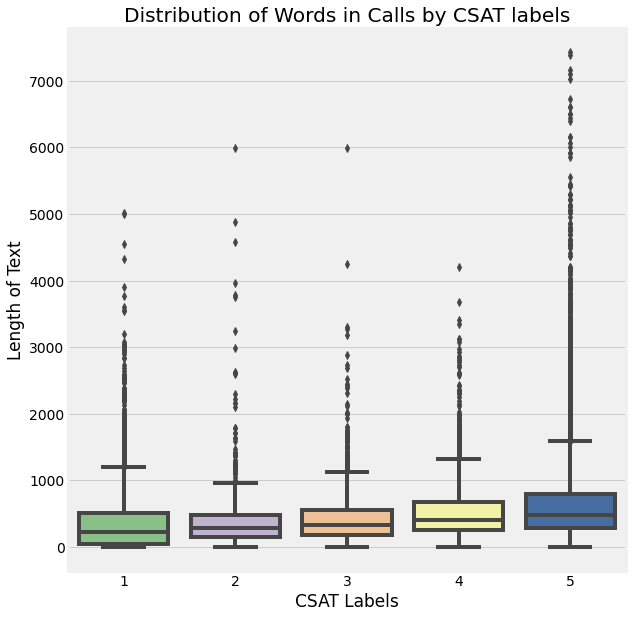

In [28]:
plt.figure(figsize=(10,10))
plt.style.use('fivethirtyeight')

#there are 5 conversations where there are more than 8,000 words
sns.boxplot(x='response_value', y='text_length', data=df4[df4.text_length < 8000], palette='Accent')

plt.ylabel('Length of Text', fontsize=17)
plt.xlabel('CSAT Labels',fontsize=17)
plt.title('Distribution of Words in Calls by CSAT labels')

plt.show()

In [29]:
df4.groupby('response_value')['text_length'].describe().reset_index()

,response_value,count,mean,std,min,25%,50%,75%,max
0,1,3217.0,384.457569,516.760112,0.0,40.0,215.0,502.00,5010.0
1,2,670.0,419.988060,576.337840,0.0,142.0,286.0,473.75,5989.0
2,3,1347.0,439.285078,459.489350,0.0,172.0,319.0,557.50,5985.0
3,4,2366.0,528.699915,448.467810,0.0,242.0,398.0,677.00,4209.0
4,5,21536.0,633.817329,602.024439,0.0,274.0,470.0,799.00,12631.0


In [30]:
df4.groupby('response_value')['bert_tokenizer_length'].describe().reset_index()

,response_value,count,mean,std,min,25%,50%,75%,max
0,1,3217.0,501.947156,671.563647,0.0,54.0,286.0,658.00,6704.0
1,2,670.0,546.570149,735.896198,0.0,194.0,378.0,620.25,7294.0
2,3,1347.0,571.816630,586.361607,0.0,230.5,419.0,728.50,7585.0
3,4,2366.0,687.418850,574.328710,0.0,321.0,521.5,874.75,5214.0
4,5,21536.0,823.361116,776.337995,0.0,362.0,612.0,1038.00,15909.0


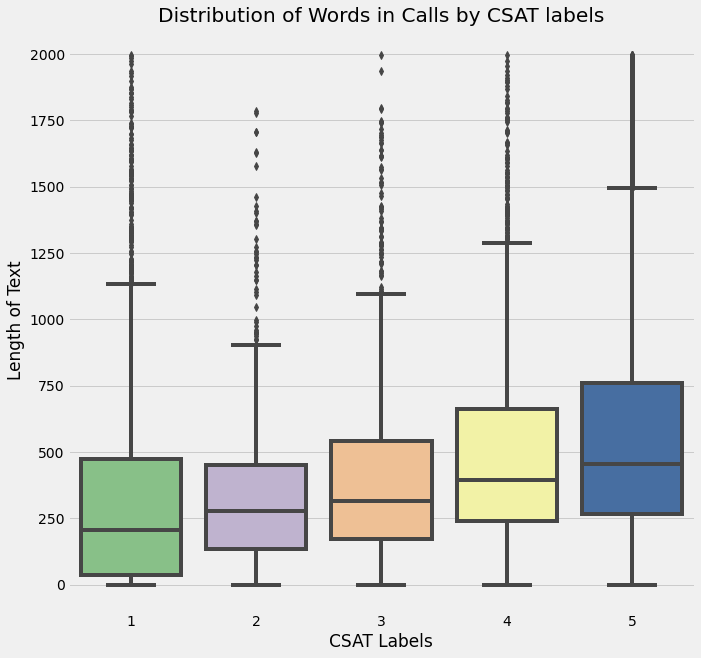

In [31]:
plt.figure(figsize=(10,10))
plt.style.use('fivethirtyeight')

#there are 5 conversations where there are more than 8,000 words
sns.boxplot(x='response_value', y='text_length', data=df4[df4.text_length < 2000], palette='Accent')

plt.ylabel('Length of Text', fontsize=17)
plt.xlabel('CSAT Labels',fontsize=17)
plt.title('Distribution of Words in Calls by CSAT labels')

plt.show()

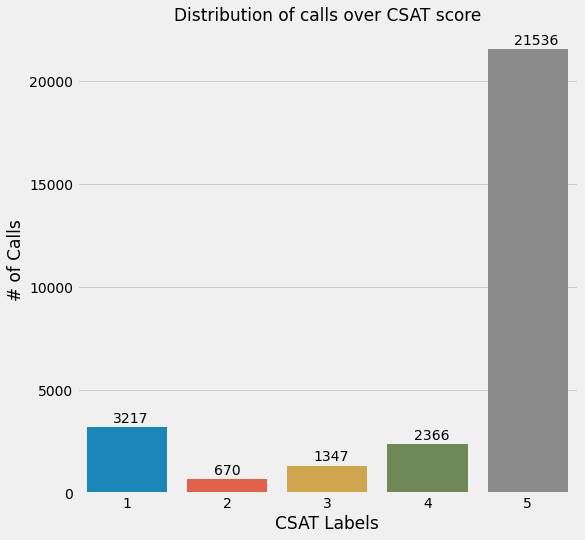

In [32]:
plt.figure(figsize=(8,8))

xc=df4['response_value'].value_counts()
axc= sns.barplot(xc.index, xc.values)

xc_labels= xc.reset_index().sort_values('index',ascending=True)['response_value'].values.tolist()
annotate_labels(axc, xc_labels)

plt.title("Distribution of calls over CSAT score", fontsize=17)
plt.ylabel('# of Calls', fontsize=17)
plt.xlabel('CSAT Labels', fontsize=17)

plt.show()

#### Creating 2 classes for negative and positive reviews

* Reviews that are 1 and 2 stars will be encoded as a NEGATIVE CSAT, 0
* Reviews that are 4 and 5 stars will be encoded as a POSITIVE CSAT, 1

We left out 3 because for some reason has many calls that are related to cancellation of a service (based on manual inspection of calls in BQ). Why is this? Is it intentional or merely a coincidence? 

In [132]:
# Encode calls with labels = 1, 2 to be negative CSAT (0) and calls with labels (4,5) to be positive CSAT (1). We left out 3 because 
filter_method = lambda x: 0 if x < 3 else 1 if (x >3) else None
dff = df4.copy()
dff['response_value'] = dff.response_value.apply(filter_method)
dff['text'] = dff['final_utterance'].str.replace(r'[^\w\s]+', '')

In [133]:
short_df = dff[dff.text_length.between(0,99)]
#df4[df4.text_length.between(71,100)].groupby(['response_value'])['call_id'].nunique()
short_df.info()
# short_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2492 entries, 28 to 29134
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   call_id                2492 non-null   object 
 1   response_value         2308 non-null   float64
 2   final_utterance        2492 non-null   object 
 3   duration               2492 non-null   float64
 4   text_length            2492 non-null   int64  
 5   bert_tokenizer_length  2492 non-null   int64  
 6   text                   2492 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 155.8+ KB


In [135]:
bins = np.arange(0,100,10)
bins[-1] = 99
labels = np.arange(1,10)
short_df['binned'] = pd.cut(short_df['text_length'].values, bins, include_lowest=True, labels=labels)
short_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length,text,binned
28,4505750192848896,0.0,thank you for contacting hotel engine are spea...,11.186,33,42,thank you for contacting hotel engine are spea...,4
29,4505867233656832,1.0,"afternoon, this is natalie from home depot hom...",36.900,93,123,afternoon this is natalie from home depot home...,9
30,4506165875441664,1.0,thank you for calling home depot installations...,68.700,72,94,thank you for calling home depot installations...,8
53,4508315577024512,0.0,no.,1.050,1,2,no,1
70,4509557773107200,0.0,"hello. well. well, i.",17.310,4,8,hello well well i,1


In [158]:
short_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2492 entries, 28 to 29134
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   call_id                2492 non-null   object  
 1   response_value         2308 non-null   float64 
 2   final_utterance        2492 non-null   object  
 3   duration               2492 non-null   float64 
 4   text_length            2492 non-null   int64   
 5   bert_tokenizer_length  2492 non-null   int64   
 6   text                   2492 non-null   object  
 7   binned                 2492 non-null   category
dtypes: category(1), float64(2), int64(2), object(3)
memory usage: 158.6+ KB


In [207]:
short_df[short_df.call_id == '5691266323251200'].final_utterance.values

array(["hello, this is julie, how can i help you? yes, madam. i'm trying to get a quote on the transport, a vehicle from manheim to bogalusa louisiana. hello."],
      dtype=object)

In [299]:
# short_df[ (short_df.binned == 7) ]['duration'].describe() 
short_df[ (short_df.binned == 6) & (short_df.duration.between(0,30))].sort_values('duration',ascending=True) #& short_df.text.str.contains('hello')
#exclude calls that are less than 10 words (bin 1)
#exclude calls that are less than 20 words (bin 2) 
#exclude calls that are less than 30 words (bin 3) and do not contain thank you / bye bye and contain 

#if last 7 words contains one or more hello, can you hear me, nobody, cut off, on hold, can i help you, waiting for a call to be picked up,  can I talk to someone?
# may I place you on a brief hold and I'll be back with you, you're breaking in and out. Nobody answered phone, being hung up on, not hear you/me
#give me one moment, Can you hold for one brief moment, sir?, give me a moment on the line. Hold on please. one moment. Hang tight for me one second.

#Bye, have a great day. Thank you, sir, appreciate it. Bye-bye.
\

#I just need to talk to somebody in care about the survey, Ah, I'm trying to reach someone and they just put me in through the survey.
#I haven't spoken to anybody today. How can I give a survey if I didn't speak to anybody? all this all this twenty second last year service without me they hung up on me.
#I haven't even spoken to anybody yet and you're already asking me to  provide  input or some kind of a survey that doesn't seem right.  #Hi was not connected to any one, call back again

,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length,text,binned
22172,6221584820142080,0.0,"hi, i'm not sure why i'm being asked to give a...",14.040,52,70,hi im not sure why im being asked to give a su...,6
8068,5129125347000320,0.0,"hi, thank you for calling deputy. this is why ...",14.252,53,61,hi thank you for calling deputy this is why so...,6
18148,5908524145115136,0.0,"thank you for calling from fitness, this is ch...",15.240,56,70,thank you for calling from fitness this is cha...,6
28572,6710821446877184,1.0,good morning. thank you for calling the street...,16.140,51,62,good morning thank you for calling the street ...,6
16101,5746868902756352,0.0,thank you for calling one to transfer case. he...,16.488,58,73,thank you for calling one to transfer case hes...,6
20868,6122943679627264,0.0,"calling the street. good afternoon, clifford h...",16.584,56,79,calling the street good afternoon clifford her...,6
12553,5476849373741056,0.0,"financial speaking, how may help you? yes, mad...",16.767,54,64,financial speaking how may help you yes madam ...,6
9646,5252676831477760,0.0,people installations by romanov this is leona ...,16.935,54,62,people installations by romanov this is leona ...,6
27569,6635143523532800,0.0,latest by romanov this is leona. how may i hel...,17.730,53,65,latest by romanov this is leona how may i help...,6
26044,6515914717855744,1.0,"thank you for calling carelinx, this is stepha...",18.330,53,72,thank you for calling carelinx this is stephan...,6


In [275]:
short_df[ (short_df.text_length < 100) & (short_df.duration.between(26,40))]

0        [enjoy, new, year, thank, you, bye, you, too, ...
1        [on, here, ill, get, back, to, you, sure, than...
2        [brief, one, question, survey, yeah, thats, fi...
3        [just, rings, to, my, customer, service, today...
4        [love, to, get, you, transferred, over, okay, ...
                               ...                        
27760    [me, one, moment, and, ill, transfer, you, ove...
27761    [a, good, day, bye, okay, great, thank, you, a...
27762    [you, okay, by, the, way, five, was, the, wors...
27763    [for, a, quick, one, question, survey, yes, ok...
27764    [a, wonderful, day, thank, you, madam, bye, yo...
Name: text, Length: 27765, dtype: object

In [713]:
dfn = dff[dff.text_length.gt(30)].reset_index()
dfn["last_10_words"] = dfn['text'].str.split().str[-10:].str.join(" ").str.strip() 

dropcall_words = ['one moment', 'hello', 'hold on', 'brief hold', 'hang tight','one second', 'breaking up', 'breaking in', 'transfer', 'hear me', 'hear you', 'hung up', 'disconnect']

# drop all calls related to disconnection
dfn = dfn[~((dfn.text_length < 100) & (dfn['last_10_words'].str.contains('|'.join(dropcall_words))))]

#drop all calls related that does not make sense / seem to get disconnected unexpectedly. 
dfn = dfn[~((dfn.text_length < 100) & (~dfn['last_10_words'].str.contains('bye')))]

#There seems to be many calls where the agent explicitly tells the customer that there will be a one question survey at the end of the call 
#so to exclude these calls, i'll search for particular strings in the last 65 words. 
dfn["last_65_words"] = dfn['text'].str.split().str[-65:].str.join(" ").str.strip() 

survey_words = ['following this call','participate','survey','one question','bye','great day','great weekend','good day', 'good weekend', 'wonderful day', 'wonderful weekend','see you','welcome']
dfn = dfn[~((dfn.text_length>100) & 
     (dfn['last_10_words'].str.contains('|'.join(dropcall_words))) &
     (~dfn['last_65_words'].str.contains('|'.join(survey_words)))
     )]

In [714]:
dfn.reset_index()

,level_0,index,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length,text,last_10_words,last_65_words
0,0,0,4503600102440960,1.0,"this is daniel. how can i help? yes, no madam....",740.589,513,694,this is daniel how can i help yes no madam b...,enjoy new year thank you bye you too thank you,survey that they sing you get you into that ro...
1,1,1,4503602697142272,0.0,"for jacob speaking. how can i help you? hi, ho...",71.019,109,146,for jacob speaking how can i help you hi how y...,on here ill get back to you sure thank you,to do it i was calling to see if i can get som...
2,2,2,4503732200472576,1.0,"thank you for calling the street, this is aman...",237.557,217,279,thank you for calling the street this is amand...,brief one question survey yeah thats fine okay...,any didnt add as much value as i thought it wo...
3,3,3,4503877562466304,1.0,"help you today? yes, i'm just calling to confi...",265.920,588,753,help you today yes im just calling to confirm ...,just rings to my customer service today okay t...,route to you and then again you are set betwee...
4,4,4,4503914235691008,1.0,"solution federal i'm an offer innovations, chr...",351.710,694,910,solution federal im an offer innovations chris...,love to get you transferred over okay sure tha...,number i would call yes madam okay this number...
...,...,...,...,...,...,...,...,...,...,...,...
26347,27760,29130,6754709141848064,1.0,"relations romanoff renovations, this is krysta...",246.650,580,759,relations romanoff renovations this is krystal...,me one moment and ill transfer you over no they,is thats correct friday we have you confirmed ...
26348,27761,29131,6755036878143488,1.0,thank you for calling caught assistance is mar...,236.361,485,665,thank you for calling caught assistance is mar...,a good day bye okay great thank you alright bye,normally of get off the server my job were usu...
26349,27762,29132,6755178035871744,0.0,"how can i help you? hi, i'm sorry, who am i sp...",327.328,819,1049,how can i help you hi im sorry who am i speaki...,you okay by the way five was the worst right,have a concern i can give you the email addres...
26350,27763,29133,6755265068204032,1.0,"thank you for calling the street, this to my s...",210.750,442,599,thank you for calling the street this to my sp...,for a quick one question survey yes okay thank...,im in and then log in again with the hangar ye...


In [709]:
# dropcall_words = ['one moment', 'hello', 'hold on', 'brief hold', 'hang tight','one second', 'breaking up', 'breaking in', 'hear me', 'hear you', 'hung up', 'disconnect']
# dfn[((dfn.text_length.gt(100)) & (dfn['last_10_words'].str.contains('|'.join(dropcall_words))))][0:20]
survey_words = ['following this call','participate','survey','one question','bye','great day','great weekend','good day', 'good weekend', 'wonderful','see you','welcome']
survey_words1 = ['following this call','participate','survey','one question','bye','great day','great weekend','good day', 'good weekend','see you','welcome']
#almost 10K calls with the 
tt = dfn[((dfn.text_length>100) & 
     (dfn['last_10_words'].str.contains('|'.join(dropcall_words))) &
     (~dfn['last_65_words'].str.contains('|'.join(survey_words)))
     )].index.values
ss = dfn[((dfn.text_length>100) & 
     (dfn['last_10_words'].str.contains('|'.join(dropcall_words))) &
     (~dfn['last_65_words'].str.contains('|'.join(survey_words1)))
     )].index.values

set1 = set(tt)
set2 = set(ss)
print(len(set1))
print(len(set2))
missing = list(sorted(set2- set1))
missing

551
554


[6511, 16769, 27724]

In [375]:
# dropcall_words = ['one moment', 'hello', 'hold on', 'brief hold', 'hang tight','one second', 'breaking up', 'breaking in','transfer']
dfn[((dfn.text_length.between(100,200)) & (~dfn['last_10_words'].str.contains('bye|great day|great weekend')))]

,index,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length,text,last_10_words
1,1,4503602697142272,0.0,"for jacob speaking. how can i help you? hi, ho...",71.019,109,146,for jacob speaking how can i help you hi how y...,on here ill get back to you sure thank you
12,12,4504500762640384,0.0,thanks for calling is for you to send me into ...,389.361,165,215,thanks for calling is for you to send me into ...,okay so again another email then confirming th...
13,13,4504639646531584,1.0,"thanks for calling mystery speaking, how can? ...",252.624,143,187,thanks for calling mystery speaking how can si...,at the end of this call okay sure okay okay
43,43,4507555967860736,1.0,"i'm trying to transport. this is martin, can y...",164.582,121,161,im trying to transport this is martin can you ...,try to contact the carrier company thank you t...
50,50,4508238548893696,1.0,"ashley, this is allen; how can i help you? hi ...",93.690,158,208,ashley this is allen how can i help you hi col...,ill send that over okay sounds good alright th...
...,...,...,...,...,...,...,...,...,...
27725,29094,6752313415106560,1.0,"see? fifty email or the austin shift, austin t...",125.160,168,225,see fifty email or the austin shift austin tha...,over well straps not link its just then you still
27731,29101,6752522697506816,0.0,how long care this is cherie. how may help you...,77.883,140,187,how long care this is cherie how may help you ...,time okay ill let them know yeah alright thank...
27733,29103,6752678212861952,1.0,"yeah. thank you, miss you. i know. yes madam t...",80.970,111,148,yeah thank you miss you i know yes madam this ...,alright thank you madam yeah thank you very mu...
27744,29114,6753437695410176,NaN,"thank you for calling the street, this is aman...",90.451,130,176,thank you for calling the street this is amand...,line for a brief one question survey sure okay...


In [ ]:
2776

243

In [365]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26905 entries, 0 to 27764
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  26905 non-null  int64  
 1   call_id                26905 non-null  object 
 2   response_value         25732 non-null  float64
 3   final_utterance        26905 non-null  object 
 4   duration               26905 non-null  float64
 5   text_length            26905 non-null  int64  
 6   bert_tokenizer_length  26905 non-null  int64  
 7   text                   26905 non-null  object 
 8   last_10_words          26905 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 2.1+ MB


In [ ]:
#if last 7 words contains one or more hello, can you hear me, nobody, cut off, on hold, can i help you, waiting for a call to be picked up,  can I talk to someone?
# may I place you on a brief hold and I'll be back with you, you're breaking in and out. Nobody answered phone, being hung up on, not hear you/me
#give me one moment, Can you hold for one brief moment, sir?, give me a moment on the line. Hold on please. one moment. Hang tight for me one second.
dropcall_words = ['one moment', 'hello', 'hold on', 'brief hold', 'hang tight','one second', 'breaking up', 'breaking in','transfer']
dfn[~dfn['last_10_words'].str.contains()]
dfn[(dfn.text_length < 100) & dfn['last_10_words'].str.contains('|'.join(dropcall_words)]
df[~df['title'].str.contains('|'.join(to_drop))]

In [310]:
dfn[(dfn.text_length < 100) & dfn['last_10_words'].str.contains('transfer')]

,index,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length,text,last_10_words
3640,3821,4805454328299520,1.0,"hi, this is genet. yeah, hi this is brian gans...",28.890,41,57,hi this is genet yeah hi this is brian gansen ...,try to transfer you just one moment okay thank...
4195,4408,4851460613668864,0.0,"thanks for, thanks for picking, hoping to help...",50.795,81,105,thanks for thanks for picking hoping to help y...,be transferring you to the right eaten stella ...
4711,4955,4895690779590656,1.0,"help you? hello. hello, how can i help you? ye...",58.327,65,85,help you hello hello how can i help you yes im...,or did you talk to somebody else jared just tr...
5294,5561,4941532883386368,0.0,"thank you for calling system. yeah. yes, hi, h...",36.362,82,108,thank you for calling system yeah yes hi how a...,go ahead and transfer you okay august the tran...
6692,7034,5050413889945600,1.0,"romanoff this is vicky may help you. yes, i'm,...",101.240,68,97,romanoff this is vicky may help you yes im im ...,sure hey im going to transfer you to hey doubt
8451,8869,5193698443067392,0.0,well transport. my name is sam. how can i help...,58.410,70,92,well transport my name is sam how can i help h...,im gonna transfer you to the appropriate team ...
11774,12347,5461544707620864,0.0,"i'm help you. hi, i received a call from renee...",18.890,36,48,im help you hi i received a call from renee he...,moment ill transfer you over to a nice thank you
12418,13024,5511653695225856,0.0,"thank you for calling the support, right? okay...",24.673,31,41,thank you for calling the support right okay h...,our existing polycom phone ive been transferre...
13352,14010,5584897859452928,1.0,"thank you for calling a solves at all, this is...",100.001,40,58,thank you for calling a solves at all this is ...,available now let me transfer you over okay yu...
16245,17063,5823802199572480,0.0,"this is adam speaking, how can i assist you? s...",81.766,89,119,this is adam speaking how can i assist you so ...,the vehicle can you just transfer to sam is all


In [245]:
for i in range (0, len(dfn.iloc[:])):
  if dfn.iloc[i].text_length < 100:
    if dfn.iloc[i].last_10_words

KeyError: ignored

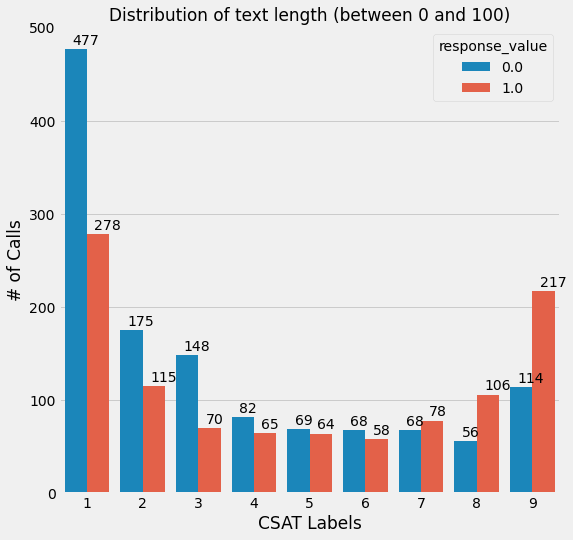

In [114]:
plt.figure(figsize=(8,8))

xc=short_df.groupby(['binned','response_value'])['duration'].count().reset_index()
ax= sns.barplot(x='binned', y='duration', hue='response_value', data=xc)

xc_labels= xc.sort_values(['response_value','binned'],ascending=True).duration.tolist()
annotate_labels(ax, xc_labels)

plt.title("Distribution of text length (between 0 and 100)", fontsize=17)
plt.ylabel('# of Calls', fontsize=17)
plt.xlabel('CSAT Labels', fontsize=17)

plt.show()

In [351]:
dff = dff[dff['response_value'].notna()]
dff = dff[dff.text_length > 5]

In [352]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27213 entries, 0 to 29135
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   call_id                27213 non-null  object 
 1   response_value         27213 non-null  float64
 2   final_utterance        27213 non-null  object 
 3   duration               27213 non-null  float64
 4   text_length            27213 non-null  int64  
 5   bert_tokenizer_length  27213 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 1.5+ MB


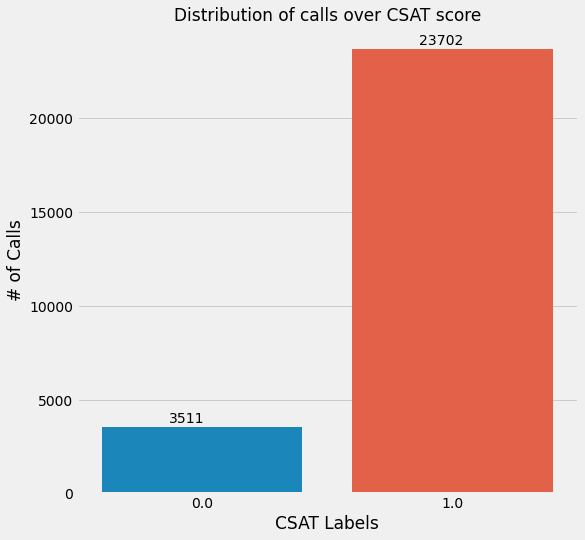

In [353]:
plt.figure(figsize=(8,8))

xc=dff['response_value'].value_counts()
axc= sns.barplot(xc.index, xc.values)

xc_labels= xc.reset_index().sort_values('index',ascending=True)['response_value'].values.tolist()
annotate_labels(axc, xc_labels)

plt.title("Distribution of calls over CSAT score", fontsize=17)
plt.ylabel('# of Calls', fontsize=17)
plt.xlabel('CSAT Labels', fontsize=17)

plt.show()

In [354]:
dff.head()

,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length
0,4503600102440960,1.0,"this is daniel. how can i help? yes, no madam....",740.589,513,694
1,4503602697142272,0.0,"for jacob speaking. how can i help you? hi, ho...",71.019,109,146
2,4503732200472576,1.0,"thank you for calling the street, this is aman...",237.557,217,279
3,4503877562466304,1.0,"help you today? yes, i'm just calling to confi...",265.920,588,753
4,4503914235691008,1.0,"solution federal i'm an offer innovations, chr...",351.710,694,910


In [355]:
#removing punctuation from text 
dff['text'] = dff['final_utterance'].str.replace(r'[^\w\s]+', '')

#apply bert tokenizer again to see some good results. 
dff['bert_tokenizer_length_no_punc'] = dff.text.apply(lambda x: len(tokenizer.tokenize(x)))

In [356]:
dff.head()

,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length,text,bert_tokenizer_length_no_punc
0,4503600102440960,1.0,"this is daniel. how can i help? yes, no madam....",740.589,513,694,this is daniel how can i help yes no madam b...,541
1,4503602697142272,0.0,"for jacob speaking. how can i help you? hi, ho...",71.019,109,146,for jacob speaking how can i help you hi how y...,112
2,4503732200472576,1.0,"thank you for calling the street, this is aman...",237.557,217,279,thank you for calling the street this is amand...,229
3,4503877562466304,1.0,"help you today? yes, i'm just calling to confi...",265.920,588,753,help you today yes im just calling to confirm ...,616
4,4503914235691008,1.0,"solution federal i'm an offer innovations, chr...",351.710,694,910,solution federal im an offer innovations chris...,720


In [357]:
# Import Drive API and authenticate.
from google.colab import drive

# Mount your Drive to the Colab VM.
drive.mount('/gdrive')

# Write the DataFrame to CSV file.
with open('/gdrive/My Drive/csat_final_v2.csv', 'w') as f:
  dff.to_csv(f)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [358]:
dfb = dff[dff.bert_tokenizer_length_no_punc <= 512]
dfb.groupby(['response_value'])['call_id'].nunique() #16.9% = minority class

response_value
0.0     2527
1.0    12457
Name: call_id, dtype: int64

In [359]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
%%time
vect = CountVectorizer()
vect.fit(dff.text)
print(len(vect.vocabulary_)) #The count vectorizer has extracted 50,667 words out of the corpus!

50667
CPU times: user 8.92 s, sys: 134 ms, total: 9.05 s
Wall time: 9.07 s


In [ ]:
%%time
neg_mat = vect.transform(dff[dff.response_value == 0].text)
pos_mat = vect.transform(dff[dff.response_value == 1].text)
neg_tf = np.sum(neg_mat,axis=0)
pos_tf = np.sum(pos_mat,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()

CPU times: user 13.4 s, sys: 67.9 ms, total: 13.5 s
Wall time: 13.5 s


In [ ]:
with open('/gdrive/My Drive/term_freq_df.csv', 'w') as f:
  term_freq_df.to_csv(f)

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
df2=pd.read_csv('gdrive/My Drive/term_freq_df.csv',header=None, skiprows=1,index_col=0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df2.head()

,1,2
0,,
00,0,9
01,1,9
015,0,2
017,0,1
02,0,5


In [ ]:
df2.columns = ['negative', 'positive']
df2['total'] = df2['negative'] + df2['positive']

In [ ]:
df2.head()

,negative,positive,total
0,,,
00,0,9,9
01,1,9,10
015,0,2,2
017,0,1,1
02,0,5,5


In [ ]:
df2.sort_values(by='total', ascending=False).iloc[:20]

,negative,positive,total
0,,,
the,53926,554154,608080
you,54303,527830,582133
to,45299,404857,450156
and,37256,400020,437276
that,29839,313573,343412
okay,25471,278404,303875
so,22100,224128,246228
it,22672,215983,238655
is,20524,199012,219536
